# Классификация текстов в Keras

---

**ФИО: Шатаров Кирилл Александрович**

---


Задание: создать модель для решения задачи классификации текста - определение тональности отзывов с использованием фреймворка Keras.

В этой работе булем решать задачу определение тональности отзывов с использованием фреймворка Keras. В ноутбуке ниже приведен пример создания нейронной сети для классификаци
и текстов на датасете, состоящим из отзывов на Tesla, бинарная лкассификация - 2 класса - позитивный отзыв и негативный отзыв. (Ссылка на датасет в примере https://drive.google.com/file/d/1PKL86ByMBl0M_rWjcjgoO29ojh9QmTU8/view?usp=sharing )

В задании для самостоятельной разработки необходимо загрузить датасет и построить 2 архитектуры сети (с использованием слоев Conv1D и SimpleRNN), вывести результаты обучения.

#### Задание
1. Для загруженного датачета отзывов создайте 2 архитектуры сети с использованием слоев Conv1D и SimpleRNN с использованием векторизации Bag of Words и Embedding.
2. Обучите сеть, добейтесь результата точности сети не менее 90% на проверочной выборке модели с использованием векторизации Bag of Words и 80% - для модели Embedding.
3. Выведите архитектуры сетей.

4. Выведите результаты и постройте матрицу ошибок.

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import re

import pickle
# import matplotlib.pyplot as plt
# %matplotlib inline
import plotly

In [5]:
def save_reviews_to_txt(directory, output_file):
    with open(output_file, 'w', encoding='utf-8') as outfile:
        for filename in os.listdir(directory):
            if filename.endswith(".txt"):
                with open(os.path.join(directory, filename), 'r', encoding='utf-8') as infile:
                    outfile.write(infile.read() + '\n')

# Путь к папкам с отзывами
train_pos_dir = 'aclImdb2/train/pos'
train_neg_dir = 'aclImdb2/train/neg'
test_pos_dir = 'aclImdb2/test/pos'
test_neg_dir = 'aclImdb2/test/neg'

# Объединение отзывов в два файла
save_reviews_to_txt(train_pos_dir, 'train_positive.txt')
save_reviews_to_txt(train_neg_dir, 'train_negative.txt')
save_reviews_to_txt(test_pos_dir, 'test_positive.txt')
save_reviews_to_txt(test_neg_dir, 'test_negative.txt')


In [9]:
def read_text(file_name):
  read_file = open(file_name, 'r', encoding='utf-8')
  text = read_file.read()
  return text.replace("\n", " ")


class_names = ["positive", "negative"] # создаем 2 класса позитивных и негативных отзывов
num_classes = len(class_names)

train_data = []
test_data = []

for i in os.listdir('./content2/train/'):
  train_data.append(read_text('./content2/train/' + i))
  print(i, 'добавлен в обучающую выборку')

for i in os.listdir('./content2/test/'):
  test_data.append(read_text('./content2/test/' + i))
  print(i, 'добавлен в тестовую выборку')

train_data_len = [len(text) for text in train_data]

train_negative.txt добавлен в обучающую выборку
train_positive.txt добавлен в обучающую выборку
test_negative.txt добавлен в тестовую выборку
test_positive.txt добавлен в тестовую выборку


In [10]:
train_data_len

[6504938, 6779800]

In [11]:
len(train_data)

2

In [12]:
# Задание параметров преобразования
VOCAB_SIZE = 10000                        # Объем словаря для токенизатора
WIN_SIZE = 500                         # Длина отрезка текста (окна) в словах
WIN_HOP = 100      

**Создание токенайзера**

In [13]:
# Создание токенайзера
tokenizer = Tokenizer(
    num_words=VOCAB_SIZE,
    filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
    lower=True,
    split=' ',
    oov_token='unknown_word',
    char_level=False
)
# Обучение токенайзера

tokenizer.fit_on_texts(train_data)
items = list(tokenizer.word_index.items())

In [14]:
# Вывод нескольких наиболее часто встречающихся слов
print(items[:15])
print("Размер словаря", len(items))

[('unknown_word', 1), ('the', 2), ('and', 3), ('a', 4), ('of', 5), ('to', 6), ('is', 7), ('br', 8), ('in', 9), ('it', 10), ('i', 11), ('this', 12), ('that', 13), ('was', 14), ('as', 15)]
Размер словаря 57036


In [15]:
# Преобразование  в последовательность
seq_train = tokenizer.texts_to_sequences(train_data)
seq_test = tokenizer.texts_to_sequences(test_data)

In [16]:
print("Фрагмент обучающего текста:")
print("В виде оригинального текста:              ", train_data[1][:90])
print("Он же в виде последовательности индексов: ", seq_train[1][:20])

Фрагмент обучающего текста:
В виде оригинального текста:               Bromwell High is a cartoon comedy. It ran at the same time as some other programs about sc
Он же в виде последовательности индексов:  [1, 288, 7, 4, 1085, 202, 10, 2252, 31, 2, 169, 59, 15, 47, 78, 5359, 42, 378, 109, 137]


In [17]:
# Функция разбиения последовательности на отрезки скользящим окном
def split_sequence(sequence, win_size, hop):
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

# Функция формирования выборок из последовательностей индексов
def vectorize_sequence(seq_list, win_size, hop):
    class_count = len(seq_list)
    x, y = [], []
    for cls in range(class_count):
        vectors = split_sequence(seq_list[cls], win_size, hop)
        x += vectors
        y += [utils.to_categorical(cls, class_count)] * len(vectors)
    return np.array(x), np.array(y)

In [18]:
#  формирование обучающей и тестовой выборок
x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(23780, 500) (23780, 2)
(23311, 500) (23311, 2)


**Векторизация текста**

**Преобразование в Bag of Words**

In [19]:
# Формирование выборок текстов в виде разреженных матриц (bag of words
# На входе .sequences_to_matrix() подается список, метод .tolist() выполняет преобразование типа

x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

In [20]:
# вывод размерности преобразованной в  bag of words обучающей выборки и 1 примера (первые 100 элементов)
print(x_train_01.shape)
print(x_train_01[0][0:100])

(23780, 10000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0.
 0. 0. 1. 0.]


In [21]:
# вывод размерности преобразованной в  bag of words тестовой выборки
x_test_01.shape

(23311, 10000)

**Создание и обучение модели (Bag of Words)**

In [86]:
model1 = Sequential([
    Dense(128, input_shape=x_test_01.shape[1:], activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(y_test.shape[1], activation='sigmoid')
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1_history = model1.fit(x_train_01, y_train, epochs=10, validation_split=0.1)

Epoch 1/10
669/669 [==============================] - 13s 19ms/step - loss: 0.0738 - accuracy: 0.9710 - val_loss: 0.5477 - val_accuracy: 0.8579
Epoch 2/10
669/669 [==============================] - 11s 17ms/step - loss: 0.0064 - accuracy: 0.9975 - val_loss: 0.7071 - val_accuracy: 0.8541
Epoch 3/10
669/669 [==============================] - 12s 17ms/step - loss: 0.0067 - accuracy: 0.9977 - val_loss: 0.8958 - val_accuracy: 0.8272
Epoch 4/10
669/669 [==============================] - 11s 17ms/step - loss: 0.0042 - accuracy: 0.9985 - val_loss: 0.7165 - val_accuracy: 0.8633
Epoch 5/10
669/669 [==============================] - 11s 17ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.4652 - val_accuracy: 0.9155
Epoch 6/10
669/669 [==============================] - 11s 17ms/step - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.4786 - val_accuracy: 0.9184
Epoch 7/10
669/669 [==============================] - 11s 17ms/step - loss: 0.0033 - accuracy: 0.9988 - val_loss: 1.1874 - val_accuracy:

**Оценка модели на тестовой выборке**

In [87]:
test_loss, test_acc = model1.evaluate(x_test_01, y_test)
print("Точность на тестовых данных:", test_acc)
print("Loss на тестовых данных:", test_loss)

729/729 [==============================] - 1s 1ms/step - loss: 0.5563 - accuracy: 0.9046
Точность на тестовых данных: 0.9046372771263123
Loss на тестовых данных: 0.5563223958015442


In [88]:
y_pred1 = model1.predict(x_test_01)

729/729 [==============================] - 1s 1ms/step


**Вывод матрицы ошибок**

In [89]:
cm1 = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred1, axis=1),
                          normalize='true')
# Округление значений матрицы ошибок
cm1 = np.around(cm1, 3)

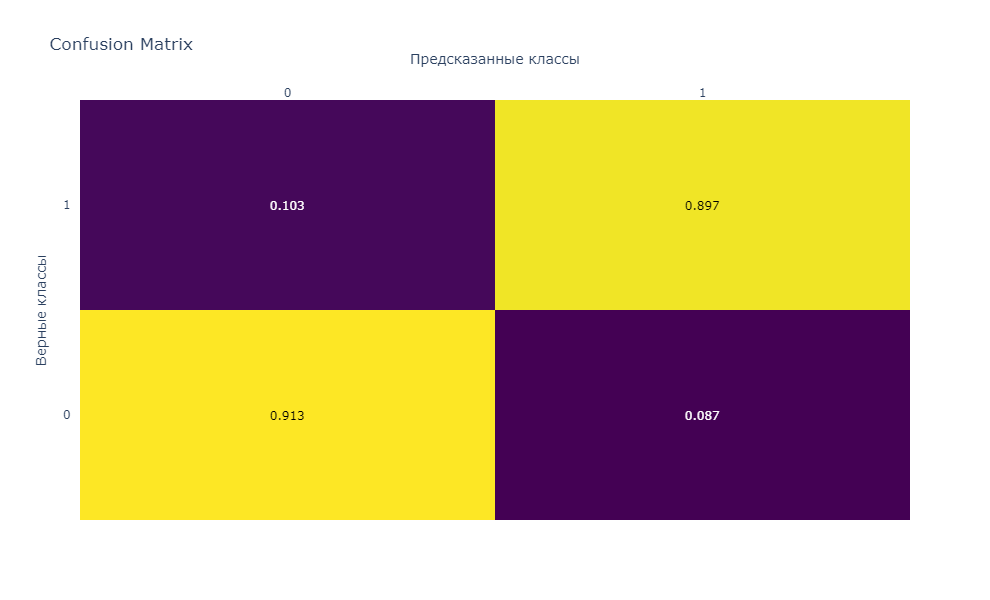

In [90]:
import plotly.graph_objects as go
import plotly.figure_factory as ff

num_classes = y_train.shape[1]

# Построение матрицы ошибок
fig = ff.create_annotated_heatmap(z=cm1, 
                                  x=[str(i) for i in range(num_classes)], 
                                  y=[str(i) for i in range(num_classes)], 
                                  colorscale='Viridis')

fig.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Предсказанные классы'),
    yaxis=dict(title='Верные классы'),
    width=600, height=600
)

fig.show()

**Создание и обучение модели (Embedding и Conv1D)**

In [75]:
# Параметры модели
input_shape = x_train.shape[1]  # Размер входного вектора
num_classes = y_train.shape[1]     # Количество классов

# Создание модели
model_conv1d = Sequential([
    Embedding(VOCAB_SIZE, 200, input_length=500),
    Conv1D(200, 5, padding='valid', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='sigmoid')
])

model_conv1d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_history = model_conv1d.fit(x_train, y_train, epochs=5, validation_split=0.1)

Epoch 1/5
669/669 [==============================] - 89s 133ms/step - loss: 0.1553 - accuracy: 0.9253 - val_loss: 0.2115 - val_accuracy: 0.9230
Epoch 2/5
669/669 [==============================] - 88s 132ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 0.2778 - val_accuracy: 0.9138
Epoch 3/5
669/669 [==============================] - 88s 131ms/step - loss: 1.3281e-04 - accuracy: 1.0000 - val_loss: 0.3481 - val_accuracy: 0.8995
Epoch 4/5
669/669 [==============================] - 88s 131ms/step - loss: 6.2832e-05 - accuracy: 1.0000 - val_loss: 0.3410 - val_accuracy: 0.9037
Epoch 5/5
669/669 [==============================] - 88s 131ms/step - loss: 3.3136e-05 - accuracy: 1.0000 - val_loss: 0.3523 - val_accuracy: 0.9050


**Оценка модели на тестовой выборке**

In [91]:
test_loss, test_acc = model_conv1d.evaluate(x_test, y_test)
print("Точность на тестовых данных:", test_acc)
print("Loss на тестовых данных:", test_loss)

729/729 [==============================] - 15s 20ms/step - loss: 0.2763 - accuracy: 0.9225
Точность на тестовых данных: 0.922482967376709
Loss на тестовых данных: 0.27630308270454407


In [76]:
y_pred_conv = model_conv1d.predict(x_test)

729/729 [==============================] - 15s 20ms/step


**Вывод матрицы ошибок**

In [77]:
cm_conv = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred_conv, axis=1),
                          normalize='true')
# Округление значений матрицы ошибок
cm_conv = np.around(cm_conv, 3)

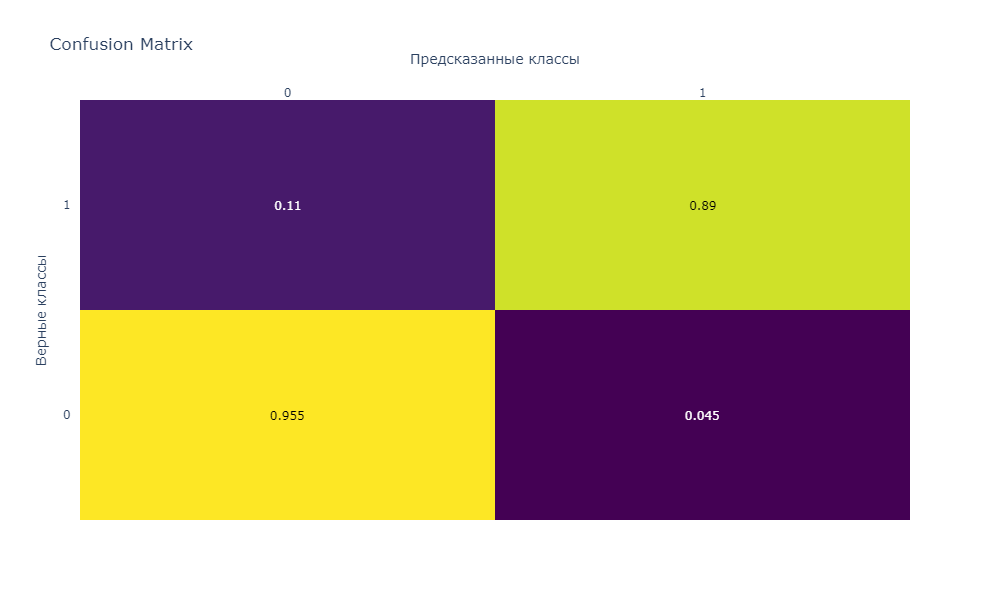

In [78]:
import plotly.graph_objects as go
import plotly.figure_factory as ff

num_classes = y_train.shape[1]

# Построение матрицы ошибок
fig = ff.create_annotated_heatmap(z=cm_conv, 
                                  x=[str(i) for i in range(num_classes)], 
                                  y=[str(i) for i in range(num_classes)], 
                                  colorscale='Viridis')

fig.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Предсказанные классы'),
    yaxis=dict(title='Верные классы'),
    width=600, height=600
)

fig.show()

**Создание и обучение модели (Embedding и SimpleRNN)**

In [ ]:
model_rnn = Sequential([
    Embedding(VOCAB_SIZE, 200, input_length=500),
    SimpleRNN(64),
    GlobalMaxPooling1D(),
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='sigmoid')
])




model_rnn = Sequential([
    Embedding(VOCAB_SIZE, 200, input_length=500),
    SimpleRNN(64),
    Dense(num_classes, activation='sigmoid')
])


In [80]:
input_shape = x_train.shape[1]  # Размер входного вектора
num_classes = y_train.shape[1]     # Количество классов

model_rnn = Sequential([
    Embedding(VOCAB_SIZE, 200, input_length=500),
    SimpleRNN(64),
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='sigmoid')
])

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
model_rnn_history = model_rnn.fit(x_train, y_train, epochs=10, validation_split=0.1)

Epoch 1/10
669/669 [==============================] - 60s 89ms/step - loss: 0.6832 - accuracy: 0.5633 - val_loss: 0.8371 - val_accuracy: 0.4844
Epoch 2/10
669/669 [==============================] - 59s 89ms/step - loss: 0.6332 - accuracy: 0.6434 - val_loss: 0.8721 - val_accuracy: 0.2708
Epoch 3/10
669/669 [==============================] - 60s 89ms/step - loss: 0.5795 - accuracy: 0.6950 - val_loss: 0.9545 - val_accuracy: 0.2696
Epoch 4/10
669/669 [==============================] - 60s 89ms/step - loss: 0.4636 - accuracy: 0.7922 - val_loss: 0.9595 - val_accuracy: 0.3621
Epoch 5/10
669/669 [==============================] - 60s 90ms/step - loss: 0.4967 - accuracy: 0.7637 - val_loss: 0.8893 - val_accuracy: 0.4584
Epoch 6/10
669/669 [==============================] - 60s 90ms/step - loss: 0.4253 - accuracy: 0.8057 - val_loss: 0.9561 - val_accuracy: 0.5715
Epoch 7/10
669/669 [==============================] - 60s 90ms/step - loss: 0.4156 - accuracy: 0.8103 - val_loss: 0.8862 - val_accuracy:

**Оценка модели на тестовой выборке**

In [81]:
y_pred_rnn = model_rnn.predict(x_test)

729/729 [==============================] - 14s 20ms/step


**Вывод матрицы ошибок**

In [82]:
cm_rnn = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred_rnn, axis=1),
                          normalize='true')
# Округление значений матрицы ошибок
cm_rnn = np.around(cm_rnn, 3)

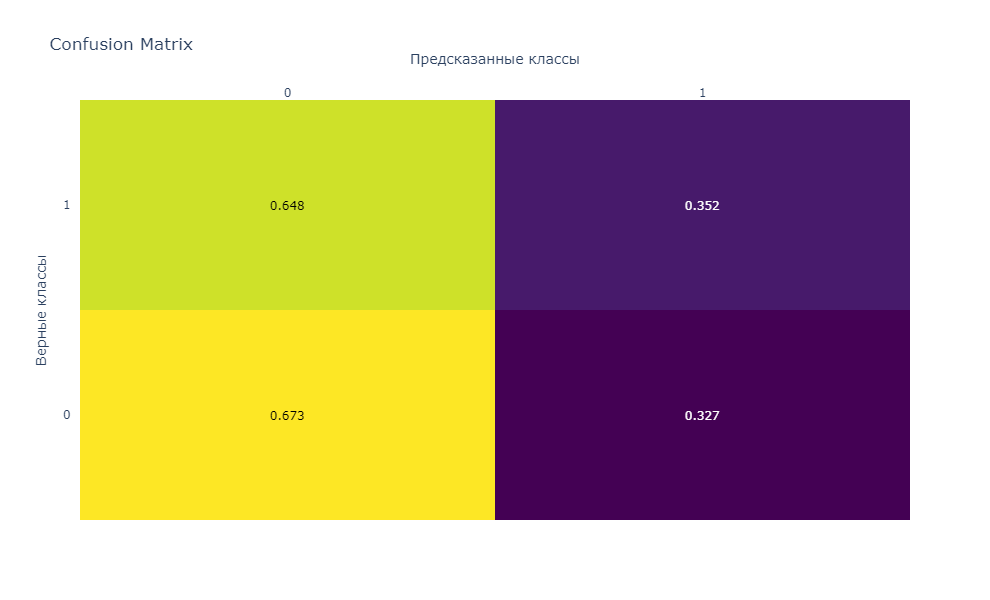

In [83]:
import plotly.graph_objects as go
import plotly.figure_factory as ff

num_classes = y_train.shape[1]

# Построение матрицы ошибок
fig = ff.create_annotated_heatmap(z=cm_rnn, 
                                  x=[str(i) for i in range(num_classes)], 
                                  y=[str(i) for i in range(num_classes)], 
                                  colorscale='Viridis')

fig.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Предсказанные классы'),
    yaxis=dict(title='Верные классы'),
    width=600, height=600
)

fig.show()

## Контрольные вопросы

**Опишите для чего нужен и как работает tokenizer**

Ваш ответ: Tokenizer — это инструмент, используемый для преобразования текста в числовые представления, которые могут быть использованы в моделях машинного обучения, таких как нейронные сети. Он разбивает текст на токены (слова или подслова), присваивает каждому токену уникальный числовой идентификатор и создаёт последовательности чисел, представляющие текст. 
   
   
**Опишите параметры tokenizer**

Ваш ответ:   
1. num_words: максимальное количество уникальных слов, которые будут сохраняться в словаре, остальные слова будут игнорироваться.   
2. filters: строка символов, которые будут удалены из текста во время токенизации.     
3. lower: преобразовывать ли текст в нижний регистр перед токенизацией.
4. split: строка, указывающая, по какому символу будет производиться разбиение текста на токены.    
5. oov_token: токен, который будет использоваться для замены слов, отсутствующих в словаре.   
6. char_level: если True, токенизация будет проводиться на уровне символов вместо уровня слов.
    
   
**Объясните концепцию векторизации Bag of Words.**

Ваш ответ: Конепция заключается в том, что каждый документ (или текст) рассматривается как мешок слов, игнорируя порядок слов в тексте и учитывая только их частоту появления. Для каждого документа составляется словарь всех уникальных слов, которые встречаются в корпусе текстов, и каждому слову присваивается уникальный индекс.
Затем каждый документ представляется в виде вектора, где каждая компонента вектора соответствует количеству вхождений соответствующего слова из словаря в данный документ. Таким образом, каждый документ представляется в виде разреженного вектора, где большинство компонент равны нулю.   
   
    
**Опишите слой Embedding и его параметры**

Ваш ответ: Слой Embedding берет целочисленные коды слов и преобразует их в плотные векторы фиксированного размера, что позволяет использовать их в качестве входных данных для последующих слоев нейронной сети.     
1. input_dim: размер словаря, то есть количество уникальных токенов.   
2. output_dim: размер векторов, в которые будут преобразовываться слова. Это размерность выходных векторов.   
3. input_length: длина входной последовательности (количество слов в каждом входном образце).    
